## B-anthracis-pXO1-analysis
#### Affinity analysis to describe lineage-specific protein modules in pXO1 Plasmids (Sections 2.5, 2.6, 2.7, 3.3, 3.4, 3.5) 

In [20]:
# === Import required libraries ===

# General
import glob
import os
import pandas as pd
import numpy as np

# Market-Baskey Analysis
from mlxtend.frequent_patterns import apriori, association_rules 
# from community import community_louvain
from functools import reduce
from itertools import combinations
import operator

# Sci-kit Learn
# from sklearn import tree
from sklearn.metrics import mutual_info_score

# Visualizations
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


# Set directories
home_dir = "/Users/williamharrigan/Desktop/Github/B-anthracis-pXO1-analysis"

### Step 1: Load and Initialize Data


In [2]:
# === Define 11 sublineages from Van Ert MN et al. 2007 ===

sublineages = {
    'kruger': ['NZ_CP076217', 'NZ_ABKG01000045', 'NZ_KN050649', 'NZ_CP076220'],
    'cneva': ['NZ_AP019732', 'NZ_CP008847', 'NZ_CP029324', 'NZ_CP076729', 'NZ_AAEN01000029', 'NZ_ABLH01000056', 'NZ_CP076188', 'NZ_CP047132'],
    'c_group': ['NZ_CP076202'],
    'ancient_a': ['NZ_CP076223', 'NZ_AP018444', 'NZ_CP116896', 'NZ_CP116893', 'NZ_CP116890'],
    'vollum': ['NC_012579', 'NZ_CP009327', 'NZ_CP076226', 'NZ_ABJC01000062'],
    'v770': ['NZ_QAEI01000007', 'NZ_QAEJ01000009', 'NZ_CP009597', 'NZ_CM003248', 'NZ_CP076211'],
    'aust_94': ['NZ_CP009340', 'NZ_CP076196', 'NZ_CP060195', 'NZ_AAES01000048', 'NZ_KN050652'],
    'sterne': ['NZ_CP139445', 'NZ_CP076199', 'NZ_CP110280', 'NZ_CP009540'],
    'ames': ['NZ_CP081176', 'NZ_CP126464', 'NZ_CP001971', 'NZ_ABLB01000067', 'NZ_CP009980', 'NC_007322', 'NC_012656'],
    'br_008_011': [
        'NZ_CP145727', 'NZ_CP096825', 'NZ_ABDN02000061', 'NZ_CP091763', 'NZ_CP009324', 'NZ_CP076193',
        'NZ_CP009316', 'NZ_CP076185', 'NZ_CP076142', 'NZ_CP076182', 'NZ_CP076158', 'NZ_CP076149',
        'NZ_CP076152', 'NZ_CP076179', 'NZ_CP076155', 'NZ_CP010853', 'NZ_CP076171', 'NZ_CP076165',
        'NZ_CP076161', 'NZ_CP076205', 'NZ_CP076208', 'NZ_CP010814', 'NZ_CP029806', 'NZ_CP076174',
        'NZ_CP076139'
    ],
    'wna': ['NZ_CP010321', 'NZ_CP076214', 'NZ_ABLT01000060', 'NZ_ABKF01000059', 'NZ_AAER01000043']
}

In [3]:
# === Load plasmid protein composition from NCBI Genome database annotations ===

plasmids = {}
annotation_files = glob.glob(f"{home_dir}/files/NCBI_genome_annotations/*")

for file_path in annotation_files:
    file_name = os.path.basename(file_path)
    plasmid_id = "_".join(file_name.split("_")[-3:-1])
    
    with open(file_path, "r") as f:
        proteins = [
            line.split("\t")[0]
            for line in f
            if not line.startswith("RefSeq/Protein ID")
        ]
    
    plasmids[plasmid_id] = proteins

# === Build sequence_df: maps each genome to its proteins ===

plasmid_df = pd.DataFrame(
    [
        (genome_id, protein)
        for genome_id, proteins in plasmids.items()
        for protein in proteins if protein
    ],
    columns=["plasmid_id", "protein_sequence_id"]
)

# === One-hot encode protein presence across genomes ===

plasmid_sequences_df = (
    plasmid_df
    .groupby(["plasmid_id", "protein_sequence_id"])["protein_sequence_id"]
    .count()
    .unstack(fill_value=0)
)

plasmid_sequences_encode = plasmid_sequences_df.map(lambda x: 1 if x != 0 else 0)

# === Preview ===
plasmid_df.head()
plasmid_sequences_encode.iloc[:5, :5]


protein_sequence_id,WP_000019180.1,WP_000019181.1,WP_000022108.1,WP_000022644.1,WP_000026994.1
plasmid_id,,,,,
NC_007322,0,0,1,1,0
NC_012579,0,0,1,1,0
NC_012656,0,0,1,1,0
NZ_AAEN01000029,0,1,1,1,1
NZ_AAER01000043,0,0,1,1,0


### Step 2: Define function to compute mutual information


In [10]:
def get_support(cluster_encode, cluster_batch):
    support_dict = {}
    total_n = len(cluster_batch)
    
    for n in range(1, total_n + 1):  
        for combo in combinations(cluster_batch, n):
            encoded = [cluster_encode[idx] for idx in combo]
            combined = reduce(operator.and_, encoded)
            support_dict[combo] = combined.sum() / len(cluster_encode)
            
            
    support_df = pd.DataFrame([support_dict]).T
    support_df.columns = ['support']
    support_df['itemsets'] = support_df.index
    support_df.reset_index(drop=True, inplace=True)
    
    return support_df

def calculate_mi_for_class(X, y, target_class, column_labels):
    """
    Calculate MI for a specific class in a one-versus-all approach.

    Parameters:
        X (list of lists or ndarray): Features (itemsets).
        y (list): Target variable.
        target_class (int): Class of interest.
        column_labels (list): Column labels corresponding to features.

    Returns:
        dict: Mutual information for each feature w.r.t. the target class.
    """
    # Transform y into a binary mask for the specific class
    binary_mask = [1 if label == target_class else 0 for label in y]

    # Convert X to numpy array for easier handling
    X = np.array(X)

    # Calculate MI for each feature
    mi_scores = {
        column_labels[i]: mutual_info_score(X[:, i], binary_mask)
        for i in range(X.shape[1])
    }

    return mi_scores

### Step 3: Compute mutual information to find lineage informative sequences


In [71]:
# === Map each plasmid ID to its sublineage label ===
# This dictionary is used to associate each plasmid with a known lineage classification
class_dict = {
    plasmid: strain
    for strain, plasmids in sublineages.items()
    for plasmid in plasmids
}

# === Extract feature matrix (X) and class labels (y) ===
# plasmid_vectors: binary presence/absence vectors for proteins per plasmid
# plasmid_classes: corresponding sublineage class labels for each plasmid
plasmid_vectors = plasmid_sequences_encode.values
plasmid_classes = [class_dict[pid] for pid in plasmid_sequences_encode.index]

# === Identify informative proteins using mutual information (MI) ===
# For each sublineage, compute MI of each protein feature with the class label
# Only keep proteins with MI > 0.1 (indicating some discriminative power)

sequences_informative_lineage = [
    key
    for sublineage in sublineages
    for key, value in calculate_mi_for_class(
        plasmid_vectors, plasmid_classes,
        target_class=sublineage,
        column_labels=plasmid_sequences_encode.columns
    ).items()
    if value > 0.1
]


### Step 4: Generate a decision tree based on lineage informative protein sequences


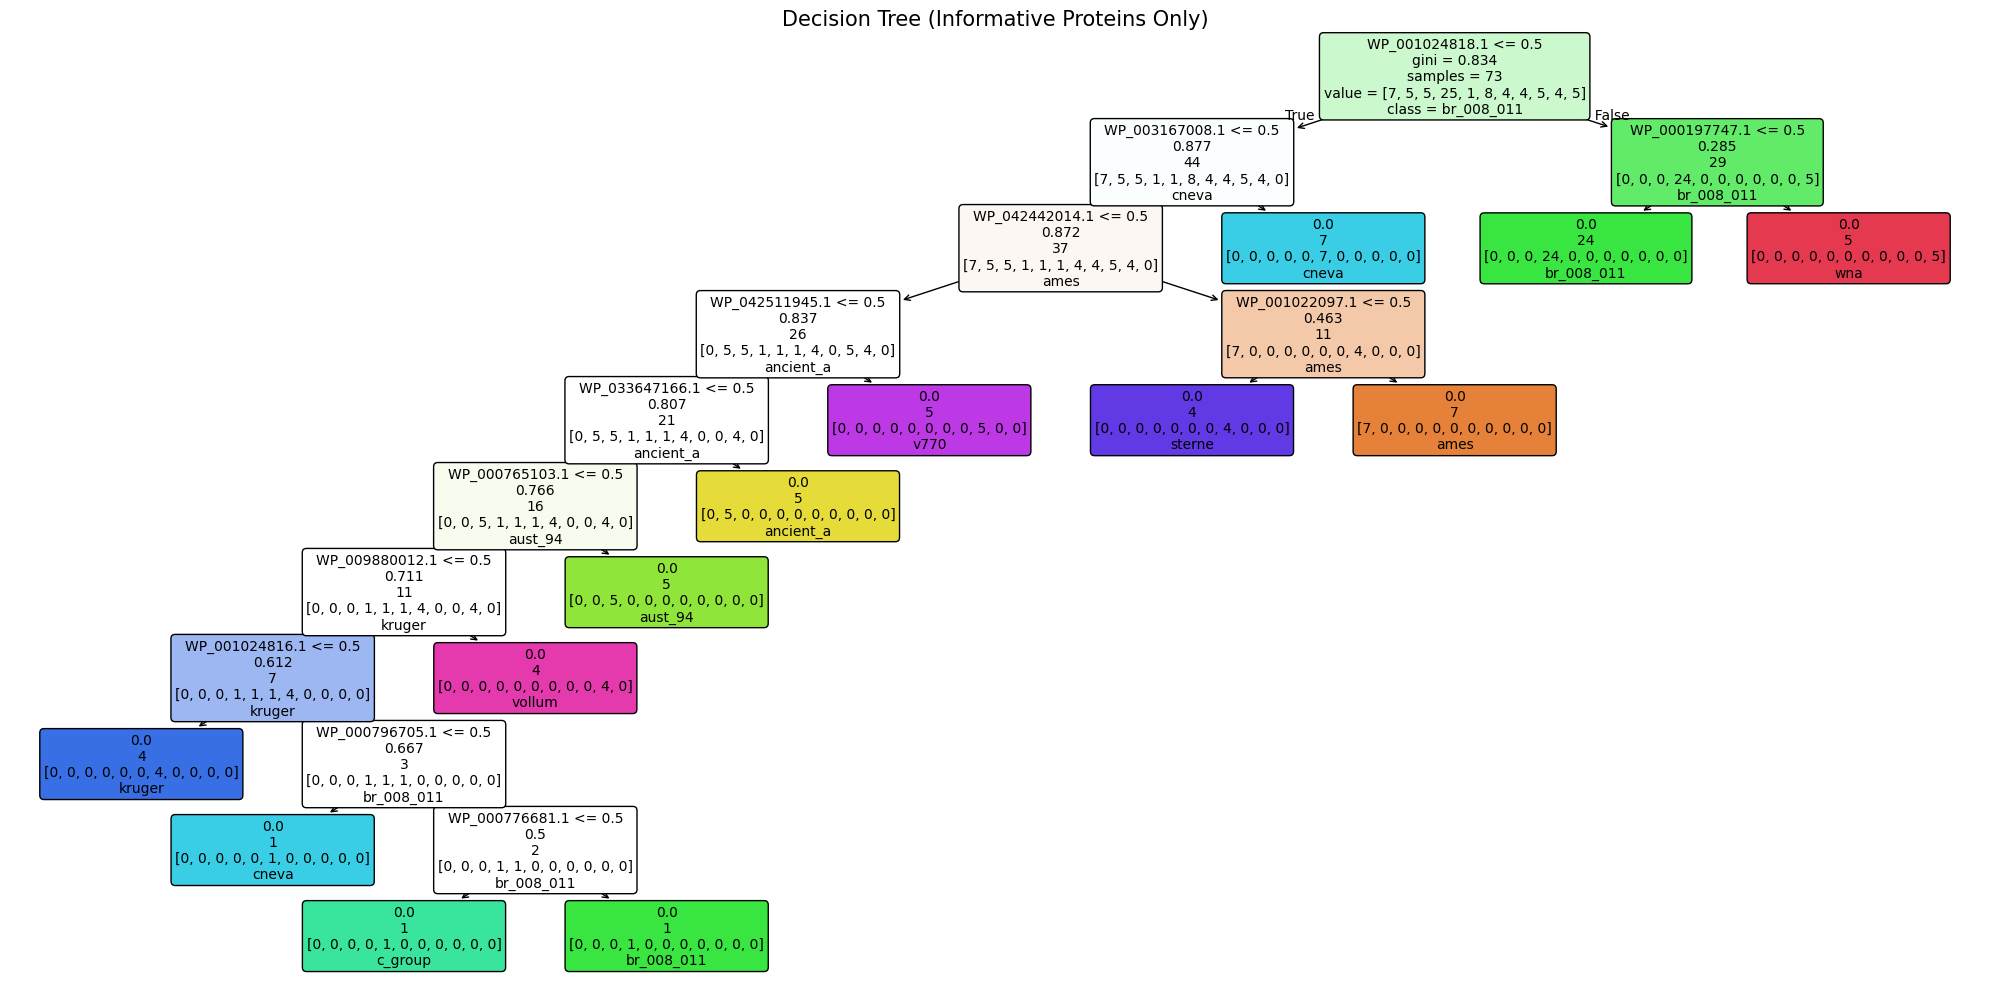

In [72]:
# === Deduplicate the final informative protein list ===
sequences_informative_lineage = list(set(sequences_informative_lineage))

# === Restrict input to only informative proteins ===
# Subset the main dataframe to only informative features
informative_df = plasmid_sequences_encode[sequences_informative_lineage]

# Ensure columns are sorted consistently to avoid mismatch
informative_df = informative_df.sort_index(axis=1)

# Get feature names in the same order as the input to fit()
feature_names = informative_df.columns.tolist()
plasmid_vectors = informative_df.values

# === Fit Decision Tree ===
clf = DecisionTreeClassifier(criterion='gini', min_samples_split=2, random_state=42)
clf.fit(plasmid_vectors, plasmid_classes)

# === Plot the tree using only informative features ===
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=clf.classes_,
    filled=True,
    rounded=True,
    fontsize=10,
    label='root'
)
plt.title("Decision Tree (Informative Proteins Only)", fontsize=15)
plt.tight_layout()
plt.show()


### References

Van Ert, M. N., Easterday, W. R., Huynh, L. Y., Okinaka, R. T., Hugh-Jones, M. E., et al. (2007).  
*Global Genetic Population Structure of Bacillus anthracis.* PLOS ONE, 2(5), e461. https://doi.org/10.1371/journal.pone.0000461
